In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import os
from functools import reduce
from tqdm import tqdm
from joblib import Parallel, delayed
tqdm.pandas() 
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from joblib import parallel_backend
import numpy as np
import importlib
import src.pca_clustering
import src.html_generator
importlib.reload(src.pca_clustering)
from src.pca_clustering import PCAProcessor,ClusteringProcessor
from sklearn.impute import SimpleImputer





# from src.data_processing import DataProcessor
from src.matching import CaseControlMatcher
# from src.pca_clustering import PCAProcessor, ClusteringProcessor
import src.rf_pipeline
importlib.reload(src.rf_pipeline)
from src.rf_pipeline import EnhancedRigorousMLPipeline
# from src.data_preparation import DataPreparation

import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import importlib


import psutil
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency, f_oneway
import warnings
import gc
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
from functools import reduce









In [3]:
print("\n=== Pipeline complet sur données volumineuses ===")
print(f"RAM disponible: {psutil.virtual_memory().available / 1e9:.2f} GB")

#===============================================================================================================================
username = "nom_db"
password = "password"
host = "serveur"  # ou l'IP de votre serveur      # A NE PAS DIVULGUER
port = "port MySQL"       # port par défaut MySQL
database = "database"

# engine = create_engine("......")
#===============================================================================================================================

# Configuration
output_dir = "output"
chunk_size = 10000
pollutant_cols = ['PM25', 'PM10', 'NO2', 'O3']
lags = [1, 2, 3, 7, 15,31]
# features_pca = pollutant_cols + ['temperature']


=== Pipeline complet sur données volumineuses ===
RAM disponible: 2.74 GB


In [4]:
# def fusion_data(engine, chunk_size, output_dir):
#     processor = DataPreparation(chunk_size=chunk_size, output_dir=output_dir)
#     processor.merge_data_chunks(engine, output_file="merged_data.csv")
#     print("Fusion terminée")

def lecture_data(output_dir, chunk_size):
    dfs = []
    for chunk in pd.read_csv(f"{output_dir}/merged_data.csv", sep=';', chunksize=chunk_size):
        dfs.append(chunk)
    df = pd.concat(dfs, ignore_index=True)
    print(f"Colonnes disponibles : {df.columns.tolist()}")
    return df



def run_matching(df, case_definition, potential_confounders,
                control_definition=None, output_csv_path=None,
                auto_matching_vars=True, manual_matching_vars=None,
                significance_threshold=0.05, effect_size_threshold=0.1,
                max_controls_per_case=1, n_jobs=-1, date_column="date_deces"):
    """
    Fonction principale pour exécuter l'analyse complète optimisée.
    
    Args:
        df: DataFrame d'entrée
        case_definition: Dict définissant les cas, ex: {'EM': ['aplasie', 'embolie']}
        potential_confounders: Liste des variables à tester comme confondants
        control_definition: Dict définissant les témoins (optionnel)
        output_csv_path: Chemin pour sauvegarder les résultats
        auto_matching_vars: Utiliser automatiquement les confondants identifiés
        manual_matching_vars: Variables d'appariement manuelles
        significance_threshold: Seuil de significativité statistique
        effect_size_threshold: Seuil de taille d'effet
        max_controls_per_case: Nombre max de témoins par cas
        n_jobs: Nombre de processus parallèles
        date_column: colonne contenant la date d’événement à propager
    
    Returns:
        Dict avec tous les résultats de l'analyse
    """
    matcher = CaseControlMatcher(n_jobs=n_jobs)

    results = matcher.run_complete_analysis(
        df=df,
        case_definition=case_definition,
        potential_confounders=potential_confounders,
        control_definition=control_definition,
        auto_matching_vars=auto_matching_vars,
        manual_matching_vars=manual_matching_vars,
        significance_threshold=significance_threshold,
        effect_size_threshold=effect_size_threshold,
        date_column=date_column
    )

    if output_csv_path and results and not results['df_matched_final'].empty:
        try:
            results['df_matched_final'].to_csv(output_csv_path, sep=';', index=False)
            print(f"💾 Résultats sauvegardés dans: {output_csv_path}")
        except Exception as e:
            print(f"❌ Erreur lors de la sauvegarde: {e}")

    return results

# ------------------------------------------------
# Préparation des dictionnaires d'accès rapide
# ------------------------------------------------

def prepare_data_dicts(df_patients, df_pollution, df_temperature):
    pollution_dict = {pseudo: df for pseudo, df in df_pollution.groupby('pseudo_provisoire')}
    temperature_dict = {pseudo: df for pseudo, df in df_temperature.groupby('pseudo_provisoire')}
    patient_dict = {pseudo: df for pseudo, df in df_patients.groupby('pseudo_provisoire')}
    return patient_dict, pollution_dict, temperature_dict



def process_patient_optimized(pseudo, df_patient, df_pollution, df_temperature, pollutant_cols, lags_days):
    if df_patient.empty:
        return None

    date_ref = pd.to_datetime(df_patient.iloc[0]["date_reference"])
    result = {"pseudo_provisoire": pseudo, "date_ref": date_ref}

    # Define thresholds for EU and WHO
    thresholds_eu = {
        'PM10': 50,
        'NO2': 200,
        'O3': 180
    }

    thresholds_who = {
        'PM25': 15,
        'PM10': 45,
        'NO2': 25,
        'O3': 100
    }

    for lag in lags_days:
        # Define the time window
        if lag == 0:
            start_date = date_ref
            end_date = date_ref
        else:
            start_date = date_ref - pd.Timedelta(days=lag - 1)
            end_date = date_ref  # Include the reference date

        # Subset pollution and temperature data
        pollution_lag = df_pollution[(df_pollution["date"] >= start_date) & (df_pollution["date"] <= end_date)].copy()
        temperature_lag = df_temperature[(df_temperature["date"] >= start_date) & (df_temperature["date"] <= end_date)].copy()

        # Save the value of the reference date (last in the window)
        for col in pollutant_cols:
            maximum = pollution_lag[col].max() if not pollution_lag.empty else None
            result[f"max_{col}_J_{lag}"] = maximum

            # --- EU Peak Calculation ---
            if col in thresholds_eu:
                threshold_eu = thresholds_eu[col]
                nb_peaks_eu = (pollution_lag[col] > threshold_eu).sum() if not pollution_lag.empty else 0
                result[f"nb_peaks_{col}_J_{lag}_EU"] = nb_peaks_eu
                result[f"peak_{col}_J_{lag}_EU"] = 1 if nb_peaks_eu > 0 else 0

            # --- WHO Peak Calculation ---
            if col in thresholds_who:
                threshold_who = thresholds_who[col]
                nb_peaks_who = (pollution_lag[col] > threshold_who).sum() if not pollution_lag.empty else 0
                result[f"nb_peaks_{col}_J_{lag}_WHO"] = nb_peaks_who
                result[f"peak_{col}_J_{lag}_WHO"] = 1 if nb_peaks_who > 0 else 0

        # Temperature on the reference date (last in the window)
        max_temp = temperature_lag["temperature"].max() if not temperature_lag.empty else None
        result[f"max_temperature_J_{lag}"] = max_temp

    return pd.DataFrame([result]).merge(df_patient, on="pseudo_provisoire", how="left")




# ------------------------------------------------
# Traitement global parallèle
# ------------------------------------------------

def parallel_processing_optimized(df_patients, df_pollution, df_temperature, pollutant_cols, lags_days,output_file, n_jobs=6):
    patient_dict, pollution_dict, temperature_dict = prepare_data_dicts(df_patients, df_pollution, df_temperature)
    pseudos = df_patients["pseudo_provisoire"].unique()

    results = []
    with parallel_backend('loky'):
        # tqdm autour de l'itérable pour afficher la progression
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_patient_optimized)(
                pseudo,
                patient_dict.get(pseudo, pd.DataFrame()),
                pollution_dict.get(pseudo, pd.DataFrame()),
                temperature_dict.get(pseudo, pd.DataFrame()),
                pollutant_cols,
                lags_days
            ) for pseudo in tqdm(pseudos, desc="Traitement patients")
        )

        results = [df for df in results if df is not None]

        if results:
            df_concat = pd.concat(results, axis=0)
            df_concat.to_csv(output_file, sep=";", index=False, mode='w')
            return df_concat
        else:
            return pd.DataFrame()

    


def pca_clustering(df, variables, PC1, PC2, n_clusters=None):     
    """     
    Exécute l'analyse en composantes principales (ACP) et le clustering K-means.      
    Args:         
    df (pd.DataFrame): Le DataFrame d'entrée.         
    
    variables (list): La liste des variables à utiliser pour l'ACP.         
    n_clusters (int, optional): Le nombre de clusters à utiliser pour le K-means.                                     
    Si None, l'algorithme utilisera le 'best_k' détecté.      
    Returns:         tuple: df_pca, df_clusters, kmeans_model, pca     
    """     
    print("Début de la PCA")     
    if df[variables].isna().all().any():         
        raise ValueError("Certaines colonnes sont entièrement NaN après conversion")          
    pca_processor = PCAProcessor(df, variables)     
    print("Variables envoyées à la PCA :", variables)     
    print("Taille du DataFrame avant PCA :", df.shape)      
    df_pca, pca = pca_processor.run_acp_complet()     
    pca_processor.plot_cercle_correlation_interactif() 
        
    # 2. Générer les éléments pour le rapport     
    # pca_processor.generate_report_assets()  # Crée plusieurs PNG + CSV  
    # 3. Créer l'interface interactive     
    src.html_generator.generate_interactive_pca_html(pca_processor, "mon_analyse_interactive.html")    
    print('Fin de la PCA')     
    print("="*50)     
    print("Début de la classification non supervisée par K-means")     
    clustering_processor = ClusteringProcessor(df_pca)          
    df_clusters, kmeans_model = clustering_processor.run_clustering(PC1, PC2, n_clusters=n_clusters)     
    print("Fin de la classification non supervisée par K-means")     
    return df_pca, df_clusters, kmeans_model, pca


def analyse_par_departement(df_cluster_dominant, cluster_col , col_statut_deces):
    """
    Analyse descriptive et statistique par département
    
    Paramètres :
    - df_cluster_dominant : DataFrame à analyser
    - col_statut_deces : Nom de la colonne indiquant le statut de décès ('oui'/'non' ou 1/0 ou booléen)
    """
    
    print("="*60)
    print("1. TAILLE DE LA COHORTE PAR DÉPARTEMENT")
    print("="*60)
    
    df = df_cluster_dominant.copy()
    
    # Détection du format de la colonne décès
    if df[col_statut_deces].dtype == 'O':  # Objet = texte
        deces_func = lambda x: (x.astype(str).str.lower() == 'oui').sum()
        taux_func = lambda x: (x.astype(str).str.lower() == 'oui').mean() * 100
    else:  # Numérique ou booléen
        deces_func = lambda x: x.sum()
        taux_func = lambda x: x.mean() * 100
    
    df['pseudo_provisoire'] = pd.to_numeric(df['pseudo_provisoire'], errors='coerce')
    
    cohorte_dept = df.groupby('CODE_DEPT').agg({
        'pseudo_provisoire': 'count',
        col_statut_deces: deces_func
    }).round(2)
    cohorte_dept.columns = ['Total_Patients', 'Décès']
    cohorte_dept['Taux_Mortalité_%'] = (cohorte_dept['Décès'] / cohorte_dept['Total_Patients'] * 100).round(2)
    cohorte_dept['%_Cohorte'] = (cohorte_dept['Total_Patients'] / cohorte_dept['Total_Patients'].sum() * 100).round(1)
    print(cohorte_dept.sort_values('Taux_Mortalité_%', ascending=False))

    print("\n" + "="*60)
    print("2. ANALYSE DE L'ÂGE PAR DÉPARTEMENT")
    print("="*60)
    
    age_analysis = df.groupby('CODE_DEPT').agg({
        'age_a_letude': ['mean', 'median', 'std', 'min', 'max']
    }).round(1)
    age_analysis.columns = ['Âge_Moyen', 'Âge_Médian', 'Écart_Type', 'Âge_Min', 'Âge_Max']
    print(age_analysis)
    
    print("\n--- Test chi2: Tranche d'âge entre départements ---")
    contingency_cat_age = pd.crosstab(df['CODE_DEPT'], df['cat_age'])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_cat_age)
    print(f"Chi2: {chi2:.3f}, p-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Différence significative d'âge entre départements")
    else:
        print("✗ Pas de différence significative d'âge entre départements")

    print("\n" + "="*60)
    print("3. ANALYSE DES COMORBIDITÉS PAR DÉPARTEMENT")
    print("="*60)
    
    patho_analysis = pd.crosstab(df['CODE_DEPT'], df['patho'], normalize='index') * 100
    print("\nRépartition des pathologies par département (%) :")
    print(patho_analysis.round(1))
    
    mortalite_patho = df.groupby('patho').agg({
        col_statut_deces: taux_func
    }).round(2)
    print("\nTaux de mortalité par pathologie :")
    print(mortalite_patho)

    print("\n" + "="*60)
    print("4. ANALYSE CROISÉE CLUSTER × DÉPARTEMENT")
    print("="*60)
    
    cluster_dept_analysis = df.groupby(['CODE_DEPT', cluster_col]).agg({
        'pseudo_provisoire': 'count',
        col_statut_deces: deces_func,
        'age_a_letude': 'mean'
    }).round(2)
    cluster_dept_analysis.columns = ['N_Patients', 'N_Décès', 'Âge_Moyen']
    cluster_dept_analysis['Taux_Mortalité_%'] = (cluster_dept_analysis['N_Décès'] / cluster_dept_analysis['N_Patients'] * 100).round(2)
    
    pivot_mortality = cluster_dept_analysis.pivot_table(
        values='Taux_Mortalité_%', 
        index='CODE_DEPT', 
        columns=cluster_col, 
        fill_value=0
    )
    print("\nTaux de mortalité par département et cluster :")
    print(pivot_mortality)

    print("\n" + "="*60)
    print("5. VISUALISATIONS")
    print("="*60)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    age_analysis['Âge_Moyen'].plot(kind='bar', color='skyblue')
    plt.title('Âge moyen par département')
    plt.ylabel('Âge (années)')
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    cohorte_dept['Taux_Mortalité_%'].plot(kind='bar', color='salmon')
    plt.title('Taux de mortalité par département')
    plt.ylabel('Taux de mortalité (%)')
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    cohorte_dept['Total_Patients'].plot(kind='bar', color='lightgreen')
    plt.title('Taille de la cohorte par département')
    plt.ylabel('Nombre de patients')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("6. CORRÉLATIONS ENTRE VARIABLES")
    print("="*60)
    
    dept_summary = df.groupby('CODE_DEPT').agg({
        'age_a_letude': 'mean',
        col_statut_deces: taux_func,
        'pseudo_provisoire': 'count'
    }).round(3)
    dept_summary.columns = ['Age_Moyen', 'Taux_Mortalite', 'Taille_Cohorte']
    
    cluster_props = df.groupby('CODE_DEPT')[cluster_col].apply(
        lambda x: x.value_counts(normalize=True)
    ).unstack(fill_value=0)
    cluster_props.columns = [f'Prop_Cluster_{col}' for col in cluster_props.columns]
    
    dept_final = pd.concat([dept_summary, cluster_props], axis=1)
    
    correlation_matrix = dept_final.corr()
    print(correlation_matrix['Taux_Mortalite'].sort_values(ascending=False))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
    plt.title('Matrice de corrélation - Facteurs par département')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("7. TESTS STATISTIQUES")

    # Ensure correct data types if not already
    df[cluster_col] = df[cluster_col].astype('category')
    df[col_statut_deces] = df[col_statut_deces].astype('category')

    # Create the contingency table
    contingency = pd.crosstab(df[cluster_col], df[col_statut_deces])

    # Perform the Chi-squared test
    chi2, p_value, dof, expected_freq = stats.chi2_contingency(contingency)

    print("--- Test Chi2 : Association cluster-décès ---")
    print(f"Chi2 Statistique: {chi2:.3f}")
    print(f"Degrés de liberté (dof): {dof}")
    print(f"P-value: {p_value:.6f}")
    if p_value < 0.05:
        print("✓ Association significative entre cluster et décès")
    else:
        print("✗ Pas d'association significative entre cluster et décès")

    print("\nTableau de Contingence (Fréquences Observées) :")
    print(contingency)

    print("\nTableau des Fréquences Attendues (sous H0 d'indépendance) :")
    # Convert expected_freq (numpy array) back to a pandas DataFrame for better readability
    expected_freq_df = pd.DataFrame(expected_freq, index=contingency.index, columns=contingency.columns)
    print(expected_freq_df.round(2)) # Round for better display

    print("\nPourcentages par Ligne :")
    print(pd.crosstab(df[cluster_col], df[col_statut_deces], normalize='index') * 100)


# def classification_supervisee(df_clusters):
#     print("Debut de la classification supervisée par Random Forest")
#     rf_pipeline = EnhancedRigorousMLPipeline(df_clusters, target_col='statut_deces_boolean')
#     rf_pipeline.run_pipeline()
#     print("fin de la classification supervisée par Random Forest")

def predict_deces(df, features, target_column, cat_var, patient_id_column='pseudo_provisoire', output_dir=None, subset_col=None, subset_values=None):
    """
    Fonction principale pour exécuter le pipeline de prédiction de décès.
    
    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        features (list): Liste des noms des colonnes à utiliser comme features.
        target_column (str): Nom de la colonne cible (e.g., 'statut_deces_boolean').
        cat_var (list): Liste des noms des colonnes catégorielles.
        patient_id_column (str, optional): Nom de la colonne d'identifiant patient pour le holdout.
                                          Defaults to 'pseudo_provisoire'.
        output_dir (str, optional): Répertoire de base pour la sortie des résultats. Defaults to None.
        subset_col (str, optional): Nom de la colonne à utiliser pour l'analyse par sous-ensembles. Defaults to None.
        subset_values (list, optional): Liste des valeurs de subset_col sur lesquelles exécuter l'analyse. Defaults to None.
    """
    print("Début de la classification supervisée par Random Forest")

    # Créez l'instance de la classe EnhancedRigorousMLPipeline
    # Assurez-vous de passer tous les arguments requis au constructeur __init__
    rf_pipeline = EnhancedRigorousMLPipeline(
        df=df,                               # Le DataFrame complet
        features=features,                   # La liste des features
        target=target_column,                # Le nom de la colonne cible
        categorical_features=cat_var,        # La liste des features catégorielles
        patient_id_col=patient_id_column   # La colonne d'ID patient pour le holdout
                    
    )

    # 1. Charger les données dans le pipeline
    X_data = df[features].copy()
    y_data = df[target_column].copy()
    rf_pipeline.load_data(X=X_data, y=y_data)

    # 2. Préparer les données (préprocesseur et split train/test)
    # Les features catégorielles et numériques sont déjà définies dans l'init du pipeline
    # et le preprocessor est créé en conséquence.
    rf_pipeline.prepare_data()

    # 3. Exécuter le pipeline (globalement ou sur des sous-ensembles)
    if subset_col and subset_values:
        # Assurez-vous que subset_col est inclus dans df (ce qui est le cas si df_clusters est passé)
        rf_pipeline.run_on_subsets(
            subset_column=subset_col,
            subsets_to_run=subset_values
        )
    else:
        rf_pipeline.run_pipeline()

    # 4. Sauvegarder les résultats et générer le rapport
    rf_pipeline.save_results()
    rf_pipeline.generate_report()

    print("Fin de la classification supervisée par Random Forest")

# Assurez-vous que la fonction conversion_to_cat est définie, par exemple :
def conversion_to_cat(df, cat_vars):
    """Convertit les colonnes spécifiées en type 'category' dans un DataFrame."""
    for col in cat_vars:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

def main_rf_pipeline(df_clusters, features_ml, cat_var, target='statut_deces_boolean', output_dir=None, subset_col=None, subset_values=None):
    # Important : assurez-vous que 'pseudo_provisoire' est inclus dans features_ml si patient_id_column est utilisé
    # et si cette colonne est nécessaire pour le split holdout par patient_id
    if 'pseudo_provisoire' not in features_ml:
        features_ml.append('pseudo_provisoire')

    features_ml = list(set(features_ml)) # Supprime les doublons après ajout
    
    print("conversion des variables catégorielles en type 'category'")
    df_clusters = conversion_to_cat(df_clusters, cat_var)
    print("Distribution de la colonne cible :")
    print(df_clusters['statut_deces_boolean'].value_counts())
    print("conversion terminée")
    print("="*50)
    print("prédiction des deces a partir des variables de pollution et de température")
    
    # Passer cat_var à predict_deces pour qu'elle puisse identifier les features catégorielles
    predict_deces(
        df_clusters, 
        features_ml, 
        'statut_deces_boolean', 
        cat_var=cat_var,    
        patient_id_column='pseudo_provisoire', 
        output_dir=output_dir, 
        subset_col=subset_col, 
        subset_values=subset_values
    )


def assign_season(row):
    mois = row['mois']
    if mois in [12, 1, 2]:
        return 'Hiver'
    elif mois in [3, 4, 5]:
        return 'Printemps'
    elif mois in [6, 7, 8]:
        return 'Été'
    elif mois in [9, 10, 11]:
        return 'Automne'
    else:
        return None

def assign_annee_season(row):
    annee = row['annee']
    mois = row['mois']
    if mois == 12:
        return annee + 1
    else:
        return annee

    



In [5]:
df = pd.read_csv('data/data_cleaned/patients_FR_IDF_geocoded_adultes_clinique_patho_statut_deces_apres_2017.csv', sep=',')
df = df.rename(columns={'date_naissance_y': 'date_naissance'})
df['date_naissance'] = pd.to_datetime(df['date_naissance'], errors='coerce')
df['date_derniere_nouvelle'] = pd.to_datetime(df['date_derniere_nouvelle'], errors='coerce')
df['age_a_letude'] = 2017 - df['date_naissance'].dt.year
df['statut_deces_boolean'] = df['statut_deces_a_letude'].replace({'oui': 1, 'non': 0})  # Exemple de mapping, ajustez selon vos données

In [5]:
# df_matched = matching (df)

In [6]:

# df_matched.columns


### ANALYSE AUX SEUILS REGLEMENTAIRES

In [ ]:
# # # Chemins
path_patients = "R:/Direction_Data/0_Projets/Projet_CANCAIR/data/data_cleaned/patients_matched.csv"
path_pollution = "R:/Direction_Data/0_Projets/Projet_CANCAIR/data/data_cleaned/pollution_data.csv"
path_temperature = r"R:\Direction_Data\0_Projets\Projet_CANCAIR\2025_Projet_Loice\Data\patients_temp_daily.csv"
patients_idf_em_path = r"R:\Direction_Data\0_Projets\Projet_CANCAIR\Canc_air_Loice\Canc_air_Loice\geocodeur\from_hegp\data\data_octobre_2023\medical_event\patients_all_idf_EM.csv"

# path_temperature = "R:/Direction_Data/0_Projets/Projet_CANCAIR/data/data_temp/patients_adultes_FR_IDF_with_statut_temp_quotidiennes.csv"

output_file = "R:/Direction_Data/0_Projets/Projet_CANCAIR/data/data_cleaned/data_final_lags.csv"
    
# Paramètres
pollutant_cols = ['PM10', 'PM25', 'NO2', 'O3']
lag_days = [0, 1, 2, 3, 7, 15, 31]
# seuils = [50, 180]


# Variables globales
df_pollution_global = None
df_temperature_global = None
df_patients_global = None
    
# Chargement unique des datasets
print("Chargement des données...")
# df_patients = pd.read_csv(path_patients, sep=";")
df_pollution = pd.read_csv(path_pollution, sep=",")
df_temperature = pd.read_csv(path_temperature, sep=",")
df_patients_em = pd.read_csv(patients_idf_em_path, sep=";")
print("Colonnes df_temp :", df_temperature.columns.tolist())
print("Colonnes df_pollution :", df_pollution.columns.tolist())


print("Données chargées avec succès")
print("="*50)
print("normalisation des dates")
df_temperature = df_temperature.rename(columns={'time': 'date'})
df_pollution["date"] = pd.to_datetime(df_pollution["date"]).dt.normalize()
df_temperature["date"] = pd.to_datetime(df_temperature["date"]).dt.normalize()
# df_matched["date_reference"] = pd.to_datetime(df_matched["date_reference"]).dt.normalize()

df_patients_em = df_patients_em.rename(columns={"EM_x":"EM"})

df_patients_em = df_patients_em.drop(columns=['EM_y'])
df_patients_em['Date_debut'] = pd.to_datetime(df_patients_em['Date_debut'])
print("Dates normalisées")
print("="*50)

Chargement des données...


In [8]:
case_definition = {'statut_deces_boolean': 1}  # ou autre événement
potential_confounders = ['age_a_letude', 'patient_sexe', 'patho', 'CODE_DEPT']

results = run_matching(
    df=df,
    case_definition=case_definition,
    potential_confounders=potential_confounders,
    output_csv_path="matched_results_1.csv",
    auto_matching_vars=True,
    n_jobs=-1,
    date_column="date_derniere_nouvelle"  # ou "date_deces", "debut_EM", etc.
)


🚀 ANALYSE COMPLÈTE CAS-TÉMOINS OPTIMISÉE (PROPAGATION DE DATE)

DÉFINITION DES CAS ET TÉMOINS
Critères de cas appliqués: {'statut_deces_boolean': 1}
Témoins: tous les individus ne satisfaisant pas les critères de cas

Résultats:
- Cas identifiés: 3990
- Témoins identifiés: 40278
- Ratio cas/témoins: 1:10.1

ANALYSE COMPLÈTE DES FACTEURS CONFONDANTS
Variables à analyser: 4
Seuil de significativité: 0.05
Seuil de taille d'effet: 0.1


Analyse confondants: 100%|██████████| 4/4 [00:00<00:00, 20.59it/s]



RÉSULTATS DES TESTS STATISTIQUES
🔴 CONFONDANT patient_sexe:
   Test: CHI2
   p-value: 0.0000
   Taille d'effet: 0.1196
   Chi2 valide: True
   AUC: nan
   OR: nan

🔴 CONFONDANT patho:
   Test: CHI2
   p-value: 0.0000
   Taille d'effet: 0.2481
   Chi2 valide: True
   AUC: nan
   OR: nan

⚪ Non significatif CODE_DEPT:
   Test: CHI2
   p-value: 0.0000
   Taille d'effet: 0.0361
   Chi2 valide: nan
   AUC: 0.500
   OR: 1.002

🔴 CONFONDANT age_a_letude:
   Test: MANNWHITNEY
   p-value: 0.0000
   Taille d'effet: 0.4991
   Médianes - Cas: 70.00, Témoins: 63.00
   AUC: 0.632
   OR: 1.036


🎯 FACTEURS CONFONDANTS IDENTIFIÉS (3):
   • patient_sexe
   • patho
   • age_a_letude

💡 Variables d'appariement automatiques: ['patient_sexe', 'patho', 'age_a_letude']

APPARIEMENT TÉMOIN-VERS-CAS (PROPAGATION DE DATE)
✅ Variables numériques (1) scalées.
✅ Variables catégorielles (2) encodées (13 nouvelles colonnes).

⚙️ Apprentissage NearestNeighbors sur les cas (3990 cas) avec 14 variables.
🔄 Recherche du

Appariement des témoins: 100%|██████████| 40278/40278 [00:00<00:00, 139889.20it/s]


✅ Appariement terminé. 3990 cas et 40278 témoins ont été inclus.

QUALITÉ DE L'APPARIEMENT (SIMILARITÉ TÉMOINS-CAS DE RÉFÉRENCE)

📊 PATIENT_SEXE:
   Proportions:
     F: Cas 64.8%, Témoins 81.5% (Δ16.7%)
     M: Cas 35.2%, Témoins 18.5% (Δ16.7%)

📊 PATHO:
   Proportions:
     Autre: Cas 0.5%, Témoins 0.3% (Δ0.3%)
     Dermato: Cas 2.4%, Témoins 1.8% (Δ0.7%)
     Endocrino: Cas 0.8%, Témoins 1.9% (Δ1.2%)
     Gastro: Cas 10.3%, Témoins 3.0% (Δ7.3%)
     Gynéco: Cas 6.9%, Témoins 4.1% (Δ2.8%)
     Hemato: Cas 4.7%, Témoins 4.1% (Δ0.7%)
     Neuro: Cas 1.5%, Témoins 0.8% (Δ0.7%)
     ORL: Cas 5.0%, Témoins 2.2% (Δ2.8%)
     Ophtalmo: Cas 2.2%, Témoins 1.9% (Δ0.3%)
     Sarcome: Cas 3.4%, Témoins 1.8% (Δ1.5%)
     Sein: Cas 38.9%, Témoins 66.7% (Δ27.8%)
     Thorax: Cas 14.1%, Témoins 2.4% (Δ11.7%)
     Uro: Cas 9.3%, Témoins 9.1% (Δ0.3%)

📊 AGE_A_LETUDE:
   Cas:    68.90 ± 14.29
   Témoins: 62.32 ± 13.86
   Différence: 6.58

🎯 QUALITÉ GLOBALE: ⚠️ À AMÉLIORER

✅ ANALYSE COMPLÈTE TERMINÉE
💾

In [9]:
df_matched = results['df_matched_final']

In [10]:
df_matched

,pseudo_provisoire,adresse,codepost,nom_commune_postal,requete,x,y,score,trust_score,street,...,date_derniere_nouvelle,statut_deces,statut_deces_a_letude,age_a_letude,statut_deces_boolean,is_case,date_reference,cas_apparie,matched_control_ids,matched_case_id
0,60,18 RUE DE LYON,75012.0,PARIS,18 RUE DE LYON 75012 PARIS,2.371734,48.847805,0.979952,high,18 Rue de Lyon,...,2019-10-03,oui,oui,85,1,True,2019-10-03,None,"339,384,388,398,450,588,958,1259,1457,2050,221...",NaN
1,134,11 BIS RUE DE LA PLANCHE,75007.0,PARIS 7E ARRONDISSEMENT,11 BIS RUE DE LA PLANCHE 75007 PARI...,2.325159,48.852571,0.502327,middle,11b Rue de la Planche,...,2019-09-07,oui,oui,39,1,True,2019-09-07,None,"1,51,285,320,348,494,522,759,905,946,1019,1851...",NaN
2,195,19 ALLE ANDR AMPERE,95200.0,SARCELLES,19 ALLE ANDR AMPERE 95200 SARCELLES,2.380362,48.976485,0.787768,middle,19 Allee Andre Ampere,...,2019-01-08,oui,oui,51,1,True,2019-01-08,None,"2536,7999,13493,29843,37187,38010,44163,45570,...",NaN
3,197,7 RUE ROUSSELET,75007.0,Paris 07,7 RUE ROUSSELET 75007 Pari...,2.318040,48.849719,0.794246,middle,7 Rue Rousselet,...,2019-04-24,oui,oui,74,1,True,2019-04-24,None,"24,2203,2581,7431,13824,15991,18480,20203,2526...",NaN
4,200,19 RUE HENRI REGNAULT,92380.0,GARCHES,19 RUE HENRI REGNAULT 92380 GARCHES,2.189318,48.847439,0.965825,high,19 Rue Henri Regnault,...,2017-12-30,oui,oui,68,1,True,2017-12-30,None,"1011,1330,1948,2116,2309,8188,12991,13765,1382...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44263,64286,15 RUE HOUSSA OUAID,77500.0,CHELLES,15 RUE HOUSSA OUAID 77500 CHELLES,2.571635,48.869009,0.803830,middle,15 Rue Houssa Ouïd,...,2023-05-12,oui,non,65,0,False,2018-12-31,4324,None,4324.0
44264,64290,3 AV DE FOUILLEUSE,92210.0,SAINT-CLOUD,3 AV DE FOUILLEUSE 92210 SAIN...,2.211229,48.861208,0.749249,middle,3 Avenue de Fouilleuse,...,2024-04-17,non,non,75,0,False,2018-11-05,37426,None,37426.0
44265,64292,60 RUE BAUDRICOURT,75013.0,Paris 13,60 RUE BAUDRICOURT 75013 Pari...,2.362960,48.825882,0.811235,middle,60 Rue Baudricourt,...,2024-03-20,non,non,73,0,False,2019-11-10,1562,None,1562.0
44266,64293,159 AVENUE DE LA REPUBLIQUE,92320.0,CHATILLON,159 AVENUE DE LA REPUBLIQUE 92320 CHAT...,2.300784,48.809219,0.970667,high,159 Avenue de la République,...,2024-05-23,non,non,71,0,False,2019-10-30,4227,None,4227.0


In [11]:
colonnes_a_imputer = ['PM10', 'PM25', 'NO2', 'O3']

# Assurez-vous que toutes les colonnes à imputer existent dans le DataFrame
colonnes_existantes = [col for col in colonnes_a_imputer if col in df_pollution.columns]

if not colonnes_existantes:
    print("\nAucune des colonnes spécifiées à imputer n'existe dans le DataFrame.")
else:
    # --- 3. Initialiser l'imputer par la médiane ---
    imputer = SimpleImputer(strategy='median')

    # --- 4. Appliquer l'imputation sur les colonnes sélectionnées ---
    # fit_transform calcule la médiane pour chaque colonne et remplace les NaN
    df_pollution[colonnes_existantes] = imputer.fit_transform(df_pollution[colonnes_existantes])

    print("\nDataFrame après imputation par la médiane :\n", df_pollution)
    print("\nNombre de valeurs manquantes après imputation :\n", df_pollution.isnull().sum())
    print(f"\nMédianes utilisées pour l'imputation (dans l'ordre des colonnes imputées) : {imputer.statistics_}")


DataFrame après imputation par la médiane :
           pseudo_provisoire       date     PM25     PM10      NO2       O3  \
0                         1 2017-08-11  11.4375  18.6250  35.8750  92.0625   
1                         2 2017-08-11  12.0625  18.1250  33.3125  81.1250   
2                         3 2017-08-11   7.7500  13.0625  12.5000  85.6875   
3                         5 2017-08-11   8.7500  15.0000  21.2500  90.8750   
4                         6 2017-08-11  11.5625  18.8750  35.0000  87.2500   
...                     ...        ...      ...      ...      ...      ...   
49156735              64286 2019-03-08   6.2500  13.9375  60.1875  81.8750   
49156736              64290 2019-03-08   5.3125  13.1250  33.6875  83.8125   
49156737              64292 2019-03-08   6.3750  14.6875  52.7500  75.5000   
49156738              64293 2019-03-08   5.6250  13.1875  43.1875  80.6875   
49156739              64294 2019-03-08   5.1875  12.5625  30.0625  84.1250   

          O3_chro

In [12]:
df_final =  parallel_processing_optimized(df_matched, df_pollution, df_temperature, pollutant_cols, lag_days, output_file)

Traitement patients: 100%|██████████| 44268/44268 [04:54<00:00, 150.36it/s]


In [53]:

print("conversion des dates de référence en datetime")

df_final['date_reference'] = pd.to_datetime(df_final['date_reference'], errors='coerce')
print("dates de référence converties en datetime")
print("="*50)
print("extraction des mois et années pour creation de la variable saison")

# Extract month and year, and apply functions
df_final['mois'] = df_final['date_reference'].dt.month
df_final['annee'] = df_final['date_reference'].dt.year
df_final['annee_saison'] = df_final.apply(assign_annee_season, axis=1)
df_final['saison'] = df_final.apply(assign_season, axis=1)
print("extraction terminée et variables saison créée")
print("="*50)
print("encodage du statut de décès en binaire")
df_final['statut_deces_boolean'] = df_final['statut_deces_a_letude'].apply(lambda x: 1 if x == 'oui' else 0)
print("encodage terminé")


conversion des dates de référence en datetime
dates de référence converties en datetime
extraction des mois et années pour creation de la variable saison
extraction terminée et variables saison créée
encodage du statut de décès en binaire
encodage terminé


In [55]:

# features_pca = ['mean_PM10_J_0', 'mean_PM25_J_0', 'mean_NO2_J_0', 'mean_O3_J_0', 'mean_temperature_J_0',
features_pca = [ 'max_PM10_J_0', 'max_PM25_J_0', 'max_NO2_J_0', 'max_O3_J_0', 'max_temperature_J_0',
                'nb_peaks_PM10_J_0_EU', 'nb_peaks_PM10_J_0_WHO', 'nb_peaks_NO2_J_0_WHO', 'nb_peaks_O3_J_0_EU', 'nb_peaks_O3_J_0_WHO','nb_peaks_PM25_J_0_WHO',
              
              # 'mean_PM10_J_1', 'mean_PM25_J_1', 'mean_NO2_J_1','mean_O3_J_1','mean_temperature_J_1',
              'max_PM10_J_1', 'max_PM25_J_1', 'max_NO2_J_1', 'max_O3_J_1', 'max_temperature_J_1',
              'nb_peaks_PM10_J_1_EU', 'nb_peaks_PM10_J_1_WHO', 'nb_peaks_NO2_J_0_WHO', 'nb_peaks_O3_J_1_EU', 'nb_peaks_O3_J_1_WHO','nb_peaks_PM25_J_1_WHO',
        
              # 'mean_PM10_J_2', 'mean_PM25_J_2', 'mean_NO2_J_2', 'mean_temperature_J_2', 
              'max_PM10_J_2', 'max_PM25_J_2', 'max_NO2_J_2', 'max_temperature_J_2', 
              'nb_peaks_PM10_J_2_EU', 'nb_peaks_PM10_J_2_WHO', 'nb_peaks_NO2_J_2_WHO', 'nb_peaks_O3_J_2_EU', 'nb_peaks_O3_J_2_WHO','nb_peaks_PM25_J_2_WHO',
       
              # 'mean_PM10_J_3', 'mean_PM25_J_3', 'mean_NO2_J_3', 'mean_O3_J_3', 'mean_temperature_J_3',
              'max_PM10_J_3', 'max_PM25_J_3', 'max_NO2_J_3', 'max_O3_J_3', 'max_temperature_J_3',
              'nb_peaks_PM10_J_3_EU', 'nb_peaks_PM10_J_3_WHO', 'nb_peaks_NO2_J_3_WHO', 'nb_peaks_O3_J_3_EU', 'nb_peaks_O3_J_3_WHO','nb_peaks_PM25_J_3_WHO',
              
              
              # 'mean_PM10_J_7', 'mean_PM25_J_7', 'mean_NO2_J_7', 'mean_O3_J_7',  'mean_temperature_J_7', 
              'max_PM10_J_7', 'max_PM25_J_7', 'max_NO2_J_7', 'max_O3_J_7',  'max_temperature_J_7', 
              'nb_peaks_PM10_J_7_EU', 'nb_peaks_PM10_J_7_WHO', 'nb_peaks_NO2_J_7_WHO', 'nb_peaks_O3_J_7_EU', 'nb_peaks_O3_J_7_WHO','nb_peaks_PM25_J_7_WHO',
      
       
              # 'mean_PM10_J_15', 'mean_PM25_J_15', 'mean_NO2_J_15', 'mean_O3_J_15', 'mean_temperature_J_15',
              'max_PM10_J_15', 'max_PM25_J_15', 'max_NO2_J_15', 'max_O3_J_15', 'max_temperature_J_15',  
              'nb_peaks_PM10_J_15_EU', 'nb_peaks_PM10_J_15_WHO', 'nb_peaks_NO2_J_15_WHO', 'nb_peaks_O3_J_15_EU', 'nb_peaks_O3_J_15_WHO','nb_peaks_PM25_J_15_WHO',
       
              # 'mean_PM10_J_31', 'mean_PM25_J_31', 'mean_NO2_J_31', 'mean_temperature_J_31',
              'max_PM10_J_31', 'max_PM25_J_31', 'max_NO2_J_31', 'max_temperature_J_31',
              'nb_peaks_PM10_J_31_EU', 'nb_peaks_PM10_J_31_WHO', 'nb_peaks_NO2_J_31_WHO', 'nb_peaks_O3_J_31_EU', 'nb_peaks_O3_J_31_WHO','nb_peaks_PM25_J_31_WHO',]

cat_var = ['cluster', 
           'peak_PM25_J_0_WHO', 'peak_PM10_J_0_EU', 'peak_PM10_J_0_WHO', 'peak_NO2_J_0_WHO', 'peak_O3_J_0_EU', 'peak_O3_J_0_WHO',
           'peak_PM25_J_1_WHO', 'peak_PM10_J_1_EU', 'peak_PM10_J_1_WHO', 'peak_NO2_J_1_WHO', 'peak_O3_J_1_EU', 'peak_O3_J_1_WHO',
           'peak_PM25_J_2_WHO', 'peak_PM10_J_2_EU', 'peak_PM10_J_2_WHO', 'peak_NO2_J_2_WHO', 'peak_O3_J_2_EU', 'peak_O3_J_2_WHO',
           'peak_PM25_J_3_WHO', 'peak_PM10_J_3_EU', 'peak_PM10_J_3_WHO', 'peak_NO2_J_3_WHO', 'peak_O3_J_3_EU', 'peak_O3_J_3_WHO',
           'peak_PM25_J_7_WHO', 'peak_PM10_J_7_EU', 'peak_PM10_J_7_WHO', 'peak_NO2_J_7_WHO', 'peak_O3_J_7_EU', 'peak_O3_J_7_WHO',
           'peak_PM25_J_15_WHO', 'peak_PM10_J_15_EU', 'peak_PM10_J_15_WHO', 'peak_NO2_J_15_WHO', 'peak_O3_J_15_EU', 'peak_O3_J_15_WHO',
           'peak_PM25_J_31_WHO', 'peak_PM10_J_31_EU', 'peak_PM10_J_31_WHO', 'peak_NO2_J_31_WHO', 'peak_O3_J_31_EU', 'peak_O3_J_31_WHO',
           'saison']


features_ml = features_pca + cat_var


Début de la PCA
Variables envoyées à la PCA : ['max_PM10_J_0', 'max_PM25_J_0', 'max_NO2_J_0', 'max_O3_J_0', 'max_temperature_J_0', 'nb_peaks_PM10_J_0_EU', 'nb_peaks_PM10_J_0_WHO', 'nb_peaks_NO2_J_0_WHO', 'nb_peaks_O3_J_0_EU', 'nb_peaks_O3_J_0_WHO', 'nb_peaks_PM25_J_0_WHO', 'max_PM10_J_1', 'max_PM25_J_1', 'max_NO2_J_1', 'max_O3_J_1', 'max_temperature_J_1', 'nb_peaks_PM10_J_1_EU', 'nb_peaks_PM10_J_1_WHO', 'nb_peaks_NO2_J_0_WHO', 'nb_peaks_O3_J_1_EU', 'nb_peaks_O3_J_1_WHO', 'nb_peaks_PM25_J_1_WHO', 'max_PM10_J_2', 'max_PM25_J_2', 'max_NO2_J_2', 'max_temperature_J_2', 'nb_peaks_PM10_J_2_EU', 'nb_peaks_PM10_J_2_WHO', 'nb_peaks_NO2_J_2_WHO', 'nb_peaks_O3_J_2_EU', 'nb_peaks_O3_J_2_WHO', 'nb_peaks_PM25_J_2_WHO', 'max_PM10_J_3', 'max_PM25_J_3', 'max_NO2_J_3', 'max_O3_J_3', 'max_temperature_J_3', 'nb_peaks_PM10_J_3_EU', 'nb_peaks_PM10_J_3_WHO', 'nb_peaks_NO2_J_3_WHO', 'nb_peaks_O3_J_3_EU', 'nb_peaks_O3_J_3_WHO', 'nb_peaks_PM25_J_3_WHO', 'max_PM10_J_7', 'max_PM25_J_7', 'max_NO2_J_7', 'max_O3_J_7'

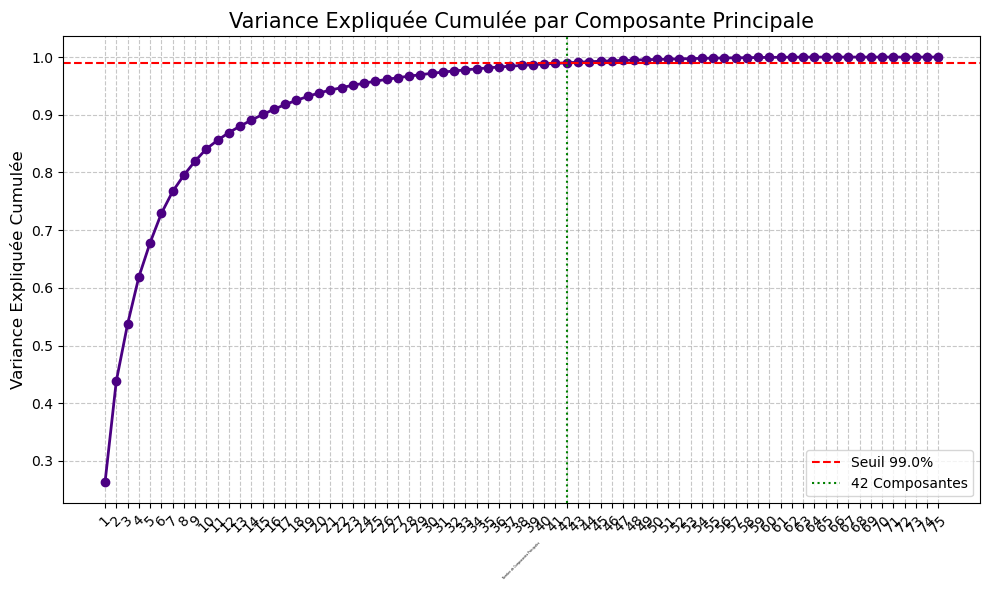

Affichage du cercle des corrélations... 🌐
Affichage des 15 variables les plus contributives. (Méthode par défaut: loadings_abs_sum) 


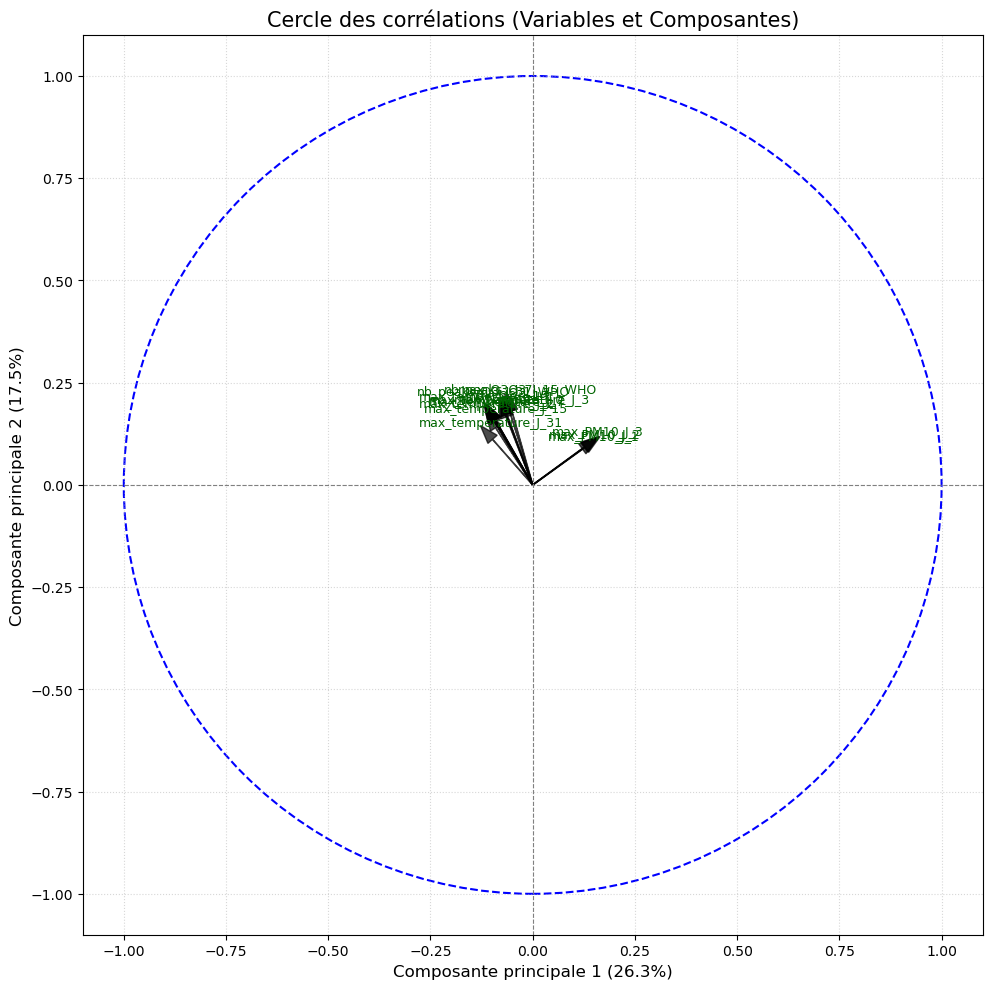

Affichage de la heatmap des contributions... 🌡️


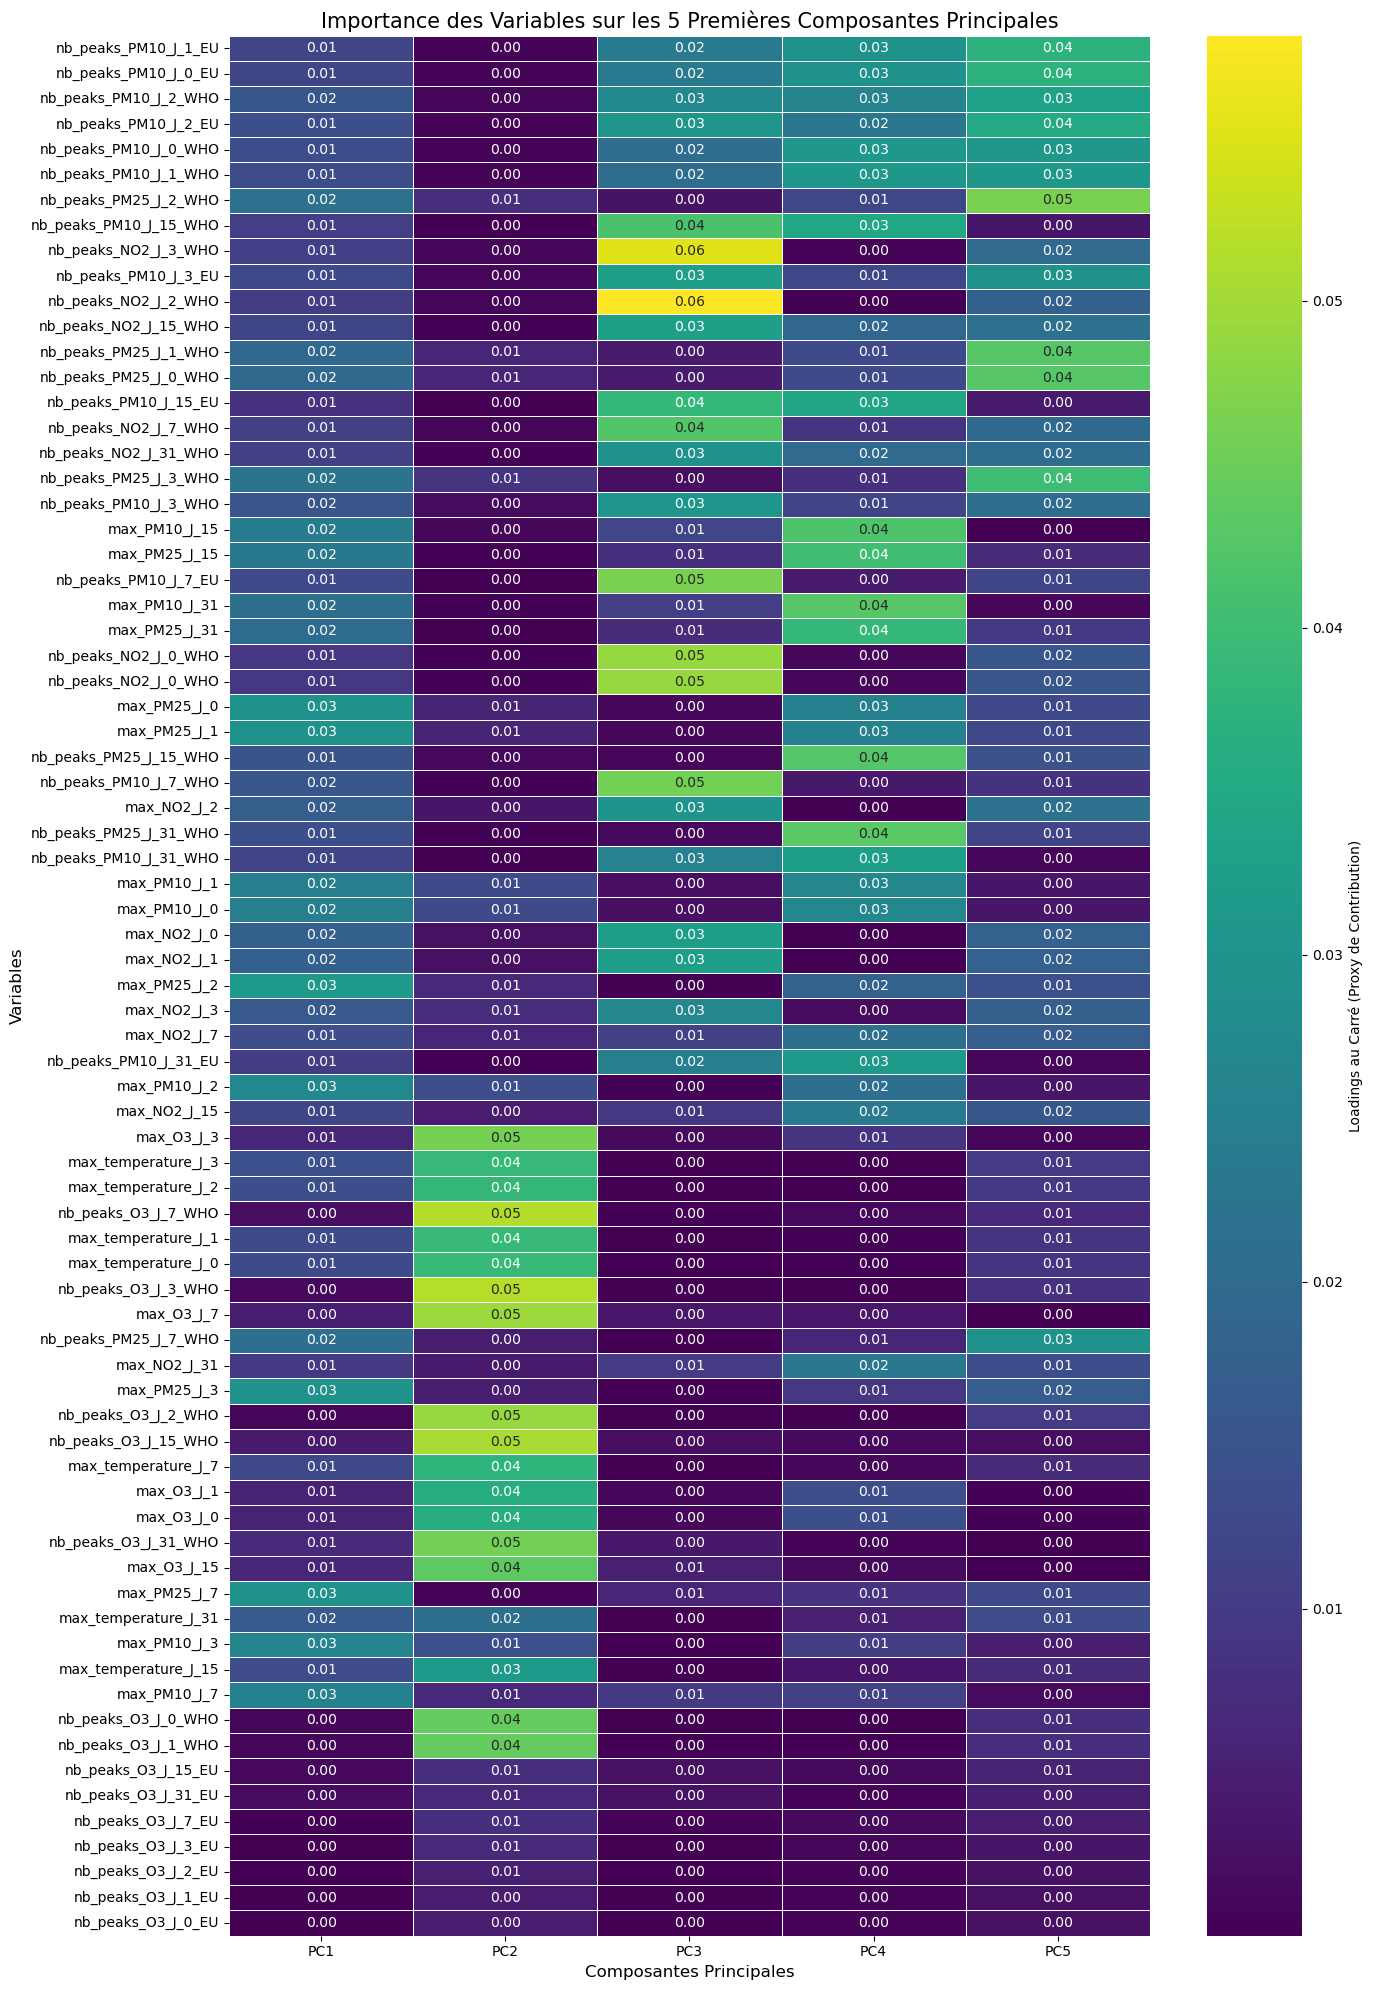

Retour de PCA : <class 'pandas.core.frame.DataFrame'> <class 'sklearn.decomposition._pca.PCA'>

--- Processus ACP terminé avec succès ! 🎉 ---
Retour de PCA : <class 'pandas.core.frame.DataFrame'> <class 'sklearn.decomposition._pca.PCA'>
Affichage interactif du cercle des corrélations... ⚡


Fichier HTML interactif généré : mon_analyse_interactive.html
Ouvrez le fichier dans votre navigateur pour utiliser l'interface interactive.
Fin de la PCA
Début de la classification non supervisée par K-means

--- Début du processus de clustering ---
Nettoyage des colonnes 'PC' terminé.
Un nombre de clusters (4) a été spécifié, la méthode du coude ne sera pas exécutée pour la détection automatique. ℹ️
Clustering final avec k = 4 (nombre de clusters spécifié manuellement)...
Clustering terminé. 4 clusters créés. ✨
Visualisation des clusters... 📊
Graphique des clusters enregistré sous 'projection_{PC1}_{PC2}.png'. 📸


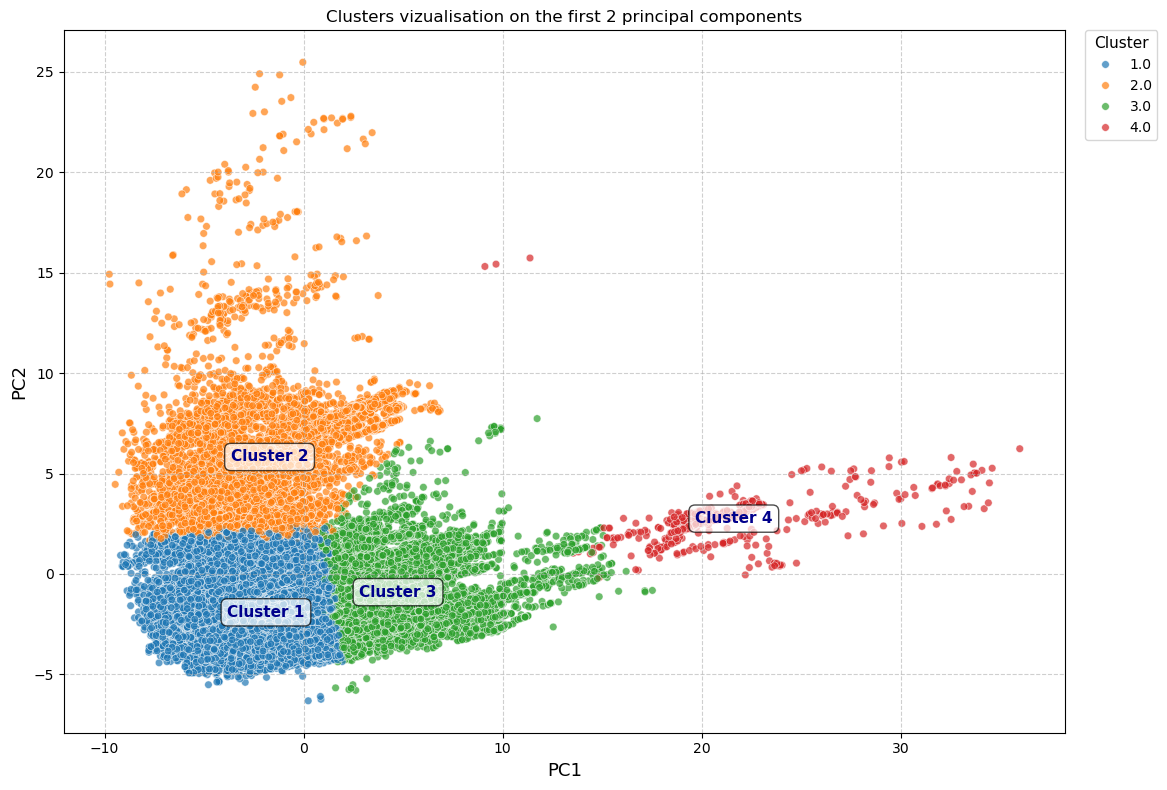

--- Processus de clustering terminé --- ✅
Fin de la classification non supervisée par K-means


In [56]:
for col in features_pca:
    df_final[col] = pd.to_numeric(df_final[col], errors="coerce")

df_pca, df_clusters, kmeans_model, pca = pca_clustering(df_final, features_pca,'PC1', 'PC2', n_clusters=4)

In [57]:
df_clusters = df_pca.merge(df_clusters[["pseudo_provisoire","cluster"]], on='pseudo_provisoire', how = 'left')

In [58]:
df_clusters['statut_deces_boolean'] = df_clusters['statut_deces_a_letude'].map({'oui': 1, 'non': 0})
df_clusters['cat_age'] = pd.cut(df_clusters['age_a_letude'], 
                                bins=[0, 35, 50, 65, 80, 120], 
                                labels=['0-35', '36-50', '51-65', '66-80', '81+'], right=False)

In [59]:
df_clusters[df_clusters['statut_deces_boolean'] == 1].groupby('patient_sexe')['pseudo_provisoire'].count().rename('N_Décès').reset_index()

,patient_sexe,N_Décès
0,F,2585
1,M,1405


1. TAILLE DE LA COHORTE PAR DÉPARTEMENT
           Total_Patients  Décès  Taux_Mortalité_%  %_Cohorte
CODE_DEPT                                                    
92                  10044   1001              9.97       22.7
75                  10795   1073              9.94       24.4
94                   3010    282              9.37        6.8
95                   2786    248              8.90        6.3
93                   3175    280              8.82        7.2
91                   2963    245              8.27        6.7
77                   2994    230              7.68        6.8
78                   8501    631              7.42       19.2

2. ANALYSE DE L'ÂGE PAR DÉPARTEMENT
           Âge_Moyen  Âge_Médian  Écart_Type  Âge_Min  Âge_Max
CODE_DEPT                                                     
75              65.1        67.0        14.0       17       99
77              59.5        60.0        13.3       17       94
78              62.5        63.0        13.7       

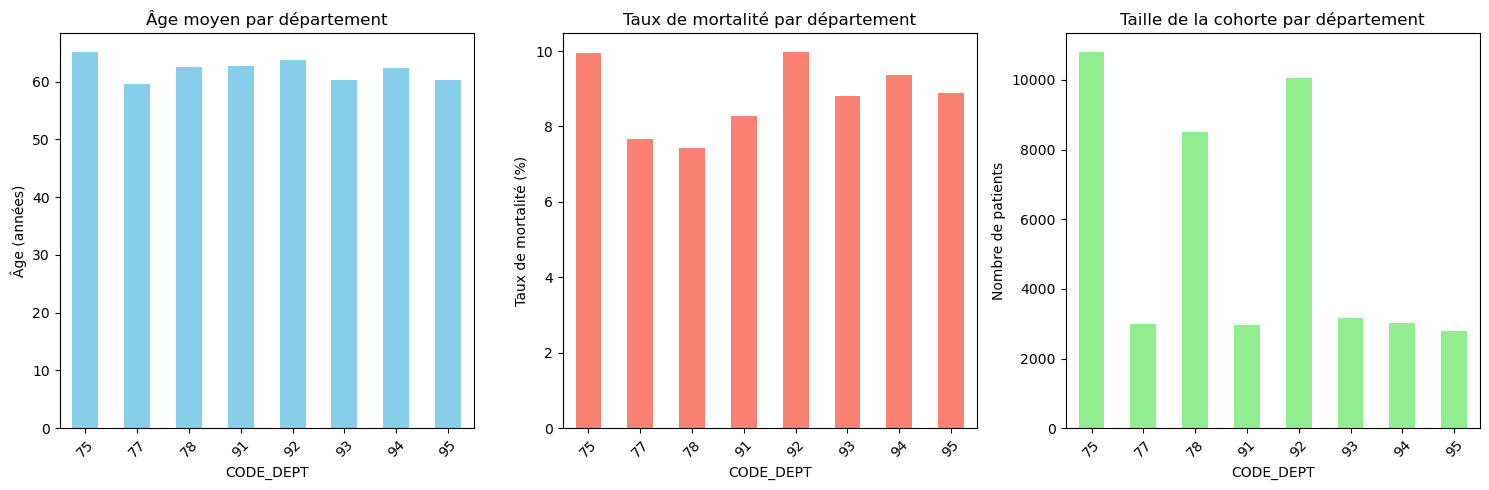


6. CORRÉLATIONS ENTRE VARIABLES
Taux_Mortalite      1.000000
Prop_Cluster_3.0    0.844958
Prop_Cluster_2.0    0.592928
Age_Moyen           0.560402
Prop_Cluster_4.0    0.477926
Taille_Cohorte      0.401328
Prop_Cluster_1.0   -0.857958
Name: Taux_Mortalite, dtype: float64


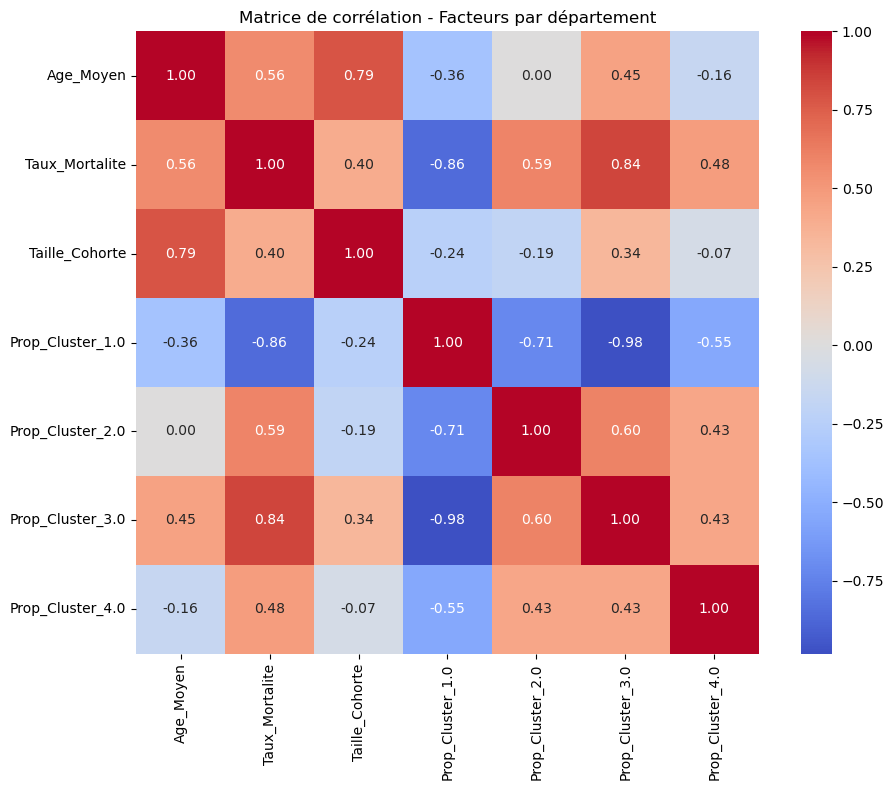


7. TESTS STATISTIQUES
--- Test Chi2 : Association cluster-décès ---
Chi2 Statistique: 88.536
Degrés de liberté (dof): 3
P-value: 0.000000
✓ Association significative entre cluster et décès

Tableau de Contingence (Fréquences Observées) :
statut_deces_boolean      0     1
cluster                          
1.0                   22079  1892
2.0                    8343   913
3.0                    9407  1117
4.0                     449    68

Tableau des Fréquences Attendues (sous H0 d'indépendance) :
statut_deces_boolean         0        1
cluster                                
1.0                   21810.43  2160.57
2.0                    8421.73   834.27
3.0                    9575.44   948.56
4.0                     470.40    46.60

Pourcentages par Ligne :
statut_deces_boolean          0          1
cluster                                   
1.0                   92.107129   7.892871
2.0                   90.136128   9.863872
3.0                   89.386165  10.613835
4.0            

In [60]:
analyse_par_departement(df_clusters, 'cluster' , 'statut_deces_boolean')

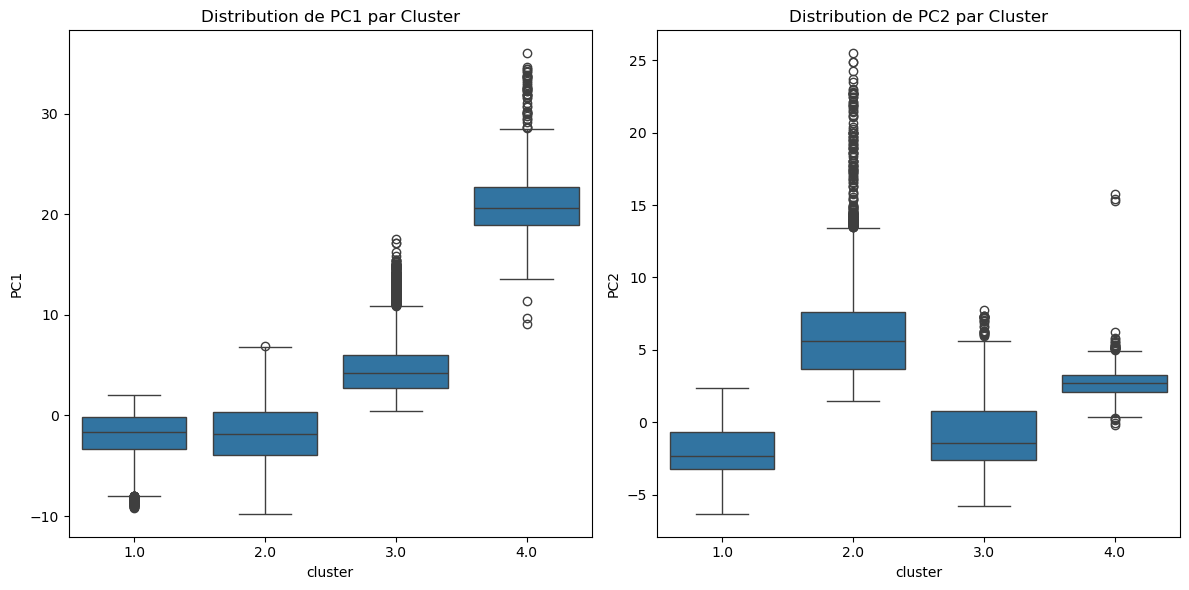

In [61]:


#boxplot des pc1 et pc2 des clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)   
sns.boxplot(x='cluster', y='PC1', data=df_clusters)
plt.title('Distribution de PC1 par Cluster')   
plt.subplot(1, 2, 2)   
sns.boxplot(x='cluster', y='PC2', data=df_clusters)
plt.title('Distribution de PC2 par Cluster')
plt.tight_layout()


In [62]:
#nombre de patients et de patients décedes par cluster
cluster_summary = df_clusters.groupby('cluster').agg(
    total_patients=('pseudo_provisoire', 'nunique'),
    total_deaths=('statut_deces_boolean', 'sum')
).reset_index()

cluster_summary['death_rate'] = cluster_summary['total_deaths'] / cluster_summary['total_patients'] * 100
cluster_summary


,cluster,total_patients,total_deaths,death_rate
0,1.0,23971,1892,7.892871
1,2.0,9256,913,9.863872
2,3.0,10524,1117,10.613835
3,4.0,517,68,13.152805


In [63]:


df_final_model = df_clusters.copy()

# Assurez-vous que les types de données sont corrects
df_final_model['cluster'] = df_final_model['cluster'].astype('category')
df_final_model['cat_age'] = df_final_model['cat_age'].astype('category')
df_final_model['patient_sexe'] = df_final_model['patient_sexe'].astype('category')
df_final_model['patho'] = df_final_model['patho'].astype('category')


# --- 1. Définir la variable dépendante (y) et les variables indépendantes (X) ---
y = df_final_model['statut_deces_boolean']

# Utilisation de drop_first=False pour obtenir toutes les dummies, puis on supprimera la référence
X_temp = pd.get_dummies(df_final_model[['cluster', 'cat_age', 'patient_sexe', 'patho']], drop_first=False)

# Maintenant, spécifions la catégorie de référence pour 'cluster'.
# Si '3.0' est la référence, nous devons supprimer la colonne 'cluster_1.0'.
if 'cluster_1.0' in X_temp.columns:
    X_temp = X_temp.drop('cluster_1.0', axis=1)
    print("Variable 'cluster_1.0' supprimée comme référence.")
else:
    print("Attention: 'cluster_1.0' n'a pas été trouvé, vérifiez les noms de colonnes ou les catégories.")

# Définir la catégorie de référence pour 'cat_age' (la plus jeune '0-35')
if 'cat_age_0-35' in X_temp.columns:
    X_temp = X_temp.drop('cat_age_0-35', axis=1)
    print("Variable 'cat_age_0-35' supprimée comme référence.")

# Définir la catégorie de référence pour 'patient_sexe' (Femme 'F')
if 'patient_sexe_F' in X_temp.columns:
    X_temp = X_temp.drop('patient_sexe_F', axis=1)
    print("Variable 'patient_sexe_F' supprimée comme référence.")

# Si 'Autre' a été créé, supprimez-le pour en faire la référence explicite.
if 'patho_Autre' in X_temp.columns:
    X_temp = X_temp.drop('patho_Autre', axis=1)
    print("Variable 'patho_Autre' supprimée comme référence.")

# Ajouter une constante pour l'intercept du modèle de régression logistique
X = sm.add_constant(X_temp, prepend=False) 

# Vérifier la présence de colonnes constantes restantes (bien que statsmodels le gère souvent)
cols_to_drop = [col for col in X.columns if X[col].nunique() == 1]
if cols_to_drop:
    print(f"Colonnes constantes détectées et supprimées: {cols_to_drop}")
    X = X.drop(columns=cols_to_drop)

# --- 3. Exécution de la régression logistique ---
print("\n=== RÉGRESSION LOGISTIQUE (Référence Cluster 1.0) ===")
logit_model_ref_cluster1 = sm.Logit(y, X)
result_ref_cluster1 = logit_model_ref_cluster1.fit()

# --- 4. Affichage des résultats ---
print(result_ref_cluster1.summary())

# --- 5. Calcul et affichage des Odds Ratios avec IC pour le nouveau modèle ---
print("\n=== ODDS RATIOS (avec Intervalles de Confiance) - Référence Cluster 3.0 ===")
odds_ratios_ref_cluster1 = pd.DataFrame({
    'OR': np.exp(result_ref_cluster1.params),
    'CI_lower': np.exp(result_ref_cluster1.conf_int()[0]),
    'CI_upper': np.exp(result_ref_cluster1.conf_int()[1]),
    'p_value': result_ref_cluster1.pvalues
})

# Filtrer et trier pour une meilleure lisibilité, surtout pour les clusters
odds_ratios_ref_cluster3_filtered = odds_ratios_ref_cluster1.loc[['cluster_2.0', 'cluster_3.0', 'cluster_4.0',
                                                                  'cat_age_36-50', 'cat_age_51-65', 'cat_age_66-80', 'cat_age_81+',
                                                                  'patient_sexe_M',
                                                                  # Ajoutez d'autres variables de patho si vous voulez les voir explicitement
                                                                  ]]
# Vous pouvez ajuster cette liste pour afficher toutes les variables que vous souhaitez.
print(odds_ratios_ref_cluster3_filtered)

# Pour toutes les variables (si vous voulez voir le tableau complet)
print("\n--- Tous les Odds Ratios ---")
print(odds_ratios_ref_cluster1)

Variable 'cluster_1.0' supprimée comme référence.
Variable 'cat_age_0-35' supprimée comme référence.
Variable 'patient_sexe_F' supprimée comme référence.
Variable 'patho_Autre' supprimée comme référence.
Colonnes constantes détectées et supprimées: ['const']

=== RÉGRESSION LOGISTIQUE (Référence Cluster 1.0) ===
Optimization terminated successfully.
         Current function value: 0.271078
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     statut_deces_boolean   No. Observations:                44268
Model:                            Logit   Df Residuals:                    44248
Method:                             MLE   Df Model:                           19
Date:               mar., 02 sept. 2025   Pseudo R-squ.:                  0.1049
Time:                          13:20:13   Log-Likelihood:                -12000.
converged:                         True   LL-Null:                       -13406.
Covariance Type: 

In [64]:
main_rf_pipeline(df_clusters, features_ml, cat_var)

conversion des variables catégorielles en type 'category'
Distribution de la colonne cible :
statut_deces_boolean
0    40278
1     3990
Name: count, dtype: int64
conversion terminée
prédiction des deces a partir des variables de pollution et de température
Début de la classification supervisée par Random Forest
Données chargées. X_shape: (44268, 119), y_shape: (44268,)

⚙️ Préparation des données...


[I 2025-09-02 13:20:21,466] A new study created in memory with name: no-name-b98e62a9-97fa-4e38-bbcc-5e6413714966


✅ Données prétraitées et divisées. X_train_processed.shape: (35414, 166), X_test_processed.shape: (8854, 166)
DEBUG: Nombre de features traitées: 166
DEBUG: Premiers noms de features traités: ['num__nb_peaks_O3_J_1_WHO' 'num__nb_peaks_PM25_J_31_WHO'
 'num__nb_peaks_PM25_J_7_WHO' 'num__nb_peaks_PM10_J_15_WHO'
 'num__nb_peaks_O3_J_15_WHO']

🚀 Démarrage du pipeline pour subset: global
📁 Répertoires de base créés pour les résultats de global:
   - Plots (base): C:/experiments/rigorous_ml\20250902_132020\plots
   - Models: C:/experiments/rigorous_ml\20250902_132020\models
   - Features: C:/experiments/rigorous_ml\20250902_132020\feature_importance
✅ Matplotlib fonctionne correctement (plot test: initial_global.png)

🔄 === Exécution de la stratégie : NoResampling ===
   📁 Répertoire des plots pour NoResampling: C:/experiments/rigorous_ml\20250902_132020\plots\NoResampling
🔍 Optimisation Optuna pour NoResampling...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-02 13:21:38,296] Trial 0 finished with value: 0.27481275593843557 and parameters: {'n_estimators': 306, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.27481275593843557.
[I 2025-09-02 13:21:52,300] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 234, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.27481275593843557.
[I 2025-09-02 13:22:20,156] Trial 2 finished with value: 0.38641855043452783 and parameters: {'n_estimators': 292, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.38641855043452783.
[I 2025-09-02 13:22:48,661] Trial 3 finished with value: 0.012605380163441714 and parameters: {'n_estimators': 335, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 7, 'm

[I 2025-09-02 13:29:58,622] A new study created in memory with name: no-name-9d5c6953-77c0-4435-ad02-8ba32a76b97a


🔍 Vérification des plots générés pour NoResampling...
 ✅ roc_pr: roc_pr_curves_NoResampling_global.png
 ✅ confusion_matrix: confusion_matrix_NoResampling_global.png
 ✅ probability_dist: probability_distribution_NoResampling_global.png
 ✅ threshold_optimization: threshold_optimization_NoResampling_global.png
 ✅ learning_curve: learning_curve_NoResampling_global.png
 ✅ builtin_importance_aggregated: feature_importance_built-in_agrégée_NoResampling_global.png
 ✅ builtin_importance_raw: feature_importance_built-in_ohe_brute_NoResampling_global.png
 ✅ permutation_importance_aggregated: feature_importance_permutation_agrégée_NoResampling_global.png
 ✅ permutation_importance_raw: feature_importance_permutation_ohe_brute_NoResampling_global.png
✅ Stratégie NoResampling terminée avec succès!
 📊 Plots générés: 9/9

🔄 === Exécution de la stratégie : BalancedRandomForest ===
   📁 Répertoire des plots pour BalancedRandomForest: C:/experiments/rigorous_ml\20250902_132020\plots\BalancedRandomForest
🔍

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-02 13:30:12,711] Trial 0 finished with value: 0.26900375065462645 and parameters: {'n_estimators': 287, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.5}. Best is trial 0 with value: 0.26900375065462645.
[I 2025-09-02 13:30:16,214] Trial 1 finished with value: 0.3411219318879525 and parameters: {'n_estimators': 146, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.3411219318879525.
[I 2025-09-02 13:30:21,617] Trial 2 finished with value: 0.30047312350172584 and parameters: {'n_estimators': 86, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 1 with value: 0.3411219318879525.
[I 2025-09-02 13:30:26,802] Trial 3 finished with value: 0.2590468258261311 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.3411219318879525.
[I 

[I 2025-09-02 13:33:57,201] A new study created in memory with name: no-name-72bd214e-85c9-4ada-a1bf-51369c37176a


🔍 Vérification des plots générés pour BalancedRandomForest...
 ✅ roc_pr: roc_pr_curves_BalancedRandomForest_global.png
 ✅ confusion_matrix: confusion_matrix_BalancedRandomForest_global.png
 ✅ probability_dist: probability_distribution_BalancedRandomForest_global.png
 ✅ threshold_optimization: threshold_optimization_BalancedRandomForest_global.png
 ✅ learning_curve: learning_curve_BalancedRandomForest_global.png
 ✅ builtin_importance_aggregated: feature_importance_built-in_agrégée_BalancedRandomForest_global.png
 ✅ builtin_importance_raw: feature_importance_built-in_ohe_brute_BalancedRandomForest_global.png
 ✅ permutation_importance_aggregated: feature_importance_permutation_agrégée_BalancedRandomForest_global.png
 ✅ permutation_importance_raw: feature_importance_permutation_ohe_brute_BalancedRandomForest_global.png
✅ Stratégie BalancedRandomForest terminée avec succès!
 📊 Plots générés: 9/9

🔄 === Exécution de la stratégie : RandomOverSampler ===
   📁 Répertoire des plots pour RandomOv

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-02 13:34:44,762] Trial 0 finished with value: 0.3481155561212913 and parameters: {'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3481155561212913.
[I 2025-09-02 13:35:15,640] Trial 1 finished with value: 0.3977967843438424 and parameters: {'n_estimators': 206, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 1 with value: 0.3977967843438424.
[I 2025-09-02 13:35:21,852] Trial 2 finished with value: 0.31847283668533505 and parameters: {'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 1 with value: 0.3977967843438424.
[I 2025-09-02 13:36:10,670] Trial 3 finished with value: 0.3996033439521394 and parameters: {'n_estimators': 353, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 5,

[I 2025-09-02 14:22:44,207] A new study created in memory with name: no-name-25cb3509-c6d6-4c76-aa37-035f9850603d


🔍 Vérification des plots générés pour RandomOverSampler...
 ✅ roc_pr: roc_pr_curves_RandomOverSampler_global.png
 ✅ confusion_matrix: confusion_matrix_RandomOverSampler_global.png
 ✅ probability_dist: probability_distribution_RandomOverSampler_global.png
 ✅ threshold_optimization: threshold_optimization_RandomOverSampler_global.png
 ✅ learning_curve: learning_curve_RandomOverSampler_global.png
 ✅ builtin_importance_aggregated: feature_importance_built-in_agrégée_RandomOverSampler_global.png
 ✅ builtin_importance_raw: feature_importance_built-in_ohe_brute_RandomOverSampler_global.png
 ✅ permutation_importance_aggregated: feature_importance_permutation_agrégée_RandomOverSampler_global.png
 ✅ permutation_importance_raw: feature_importance_permutation_ohe_brute_RandomOverSampler_global.png
✅ Stratégie RandomOverSampler terminée avec succès!
 📊 Plots générés: 9/9

🔄 === Exécution de la stratégie : RandomUnderSampler ===
   📁 Répertoire des plots pour RandomUnderSampler: C:/experiments/rigor

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-02 14:22:45,547] Trial 0 finished with value: 0.30017347699267544 and parameters: {'n_estimators': 201, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.30017347699267544.
[I 2025-09-02 14:22:52,990] Trial 1 finished with value: 0.35222311767849124 and parameters: {'n_estimators': 133, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': None}. Best is trial 1 with value: 0.35222311767849124.
[I 2025-09-02 14:22:58,320] Trial 2 finished with value: 0.34707793900853234 and parameters: {'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': None}. Best is trial 1 with value: 0.35222311767849124.
[I 2025-09-02 14:23:04,074] Trial 3 finished with value: 0.29475173178797404 and parameters: {'n_estimators': 180, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_f

[I 2025-09-02 14:24:27,847] A new study created in memory with name: no-name-0f0f9074-bc79-4be2-96bc-264303c643e6


    🔄 Génération plot importance par permutation (brute OHE)...
🔍 Vérification des plots générés pour RandomUnderSampler...
 ✅ roc_pr: roc_pr_curves_RandomUnderSampler_global.png
 ✅ confusion_matrix: confusion_matrix_RandomUnderSampler_global.png
 ✅ probability_dist: probability_distribution_RandomUnderSampler_global.png
 ✅ threshold_optimization: threshold_optimization_RandomUnderSampler_global.png
 ✅ learning_curve: learning_curve_RandomUnderSampler_global.png
 ✅ builtin_importance_aggregated: feature_importance_built-in_agrégée_RandomUnderSampler_global.png
 ✅ builtin_importance_raw: feature_importance_built-in_ohe_brute_RandomUnderSampler_global.png
 ✅ permutation_importance_aggregated: feature_importance_permutation_agrégée_RandomUnderSampler_global.png
 ✅ permutation_importance_raw: feature_importance_permutation_ohe_brute_RandomUnderSampler_global.png
✅ Stratégie RandomUnderSampler terminée avec succès!
 📊 Plots générés: 9/9

🔄 === Exécution de la stratégie : SMOTEENN ===
   📁 R

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-02 14:25:38,312] Trial 0 finished with value: 0.2558921952860002 and parameters: {'n_estimators': 445, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.2558921952860002.
[I 2025-09-02 14:28:38,988] Trial 1 finished with value: 0.334302060252086 and parameters: {'n_estimators': 165, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.7, 'class_weight': None}. Best is trial 1 with value: 0.334302060252086.
[I 2025-09-02 14:33:16,560] Trial 2 finished with value: 0.34525459346719894 and parameters: {'n_estimators': 346, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.5, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.34525459346719894.
[I 2025-09-02 14:40:07,550] Trial 3 finished with value: 0.35914569800176793 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_split': 14, 'm

AttributeError: 'EnhancedRigorousMLPipeline' object has no attribute 'save_results'